# Convolutional Neural Networks: A Visual and Mathematical Journey

Welcome to this comprehensive tutorial on Convolutional Neural Networks (CNNs)! This notebook is designed for graduate students in data science with backgrounds in mathematics, computer science, and statistics.

## Learning Objectives
By the end of this tutorial, you will understand:
- The mathematical foundations of convolution operations
- How CNN layers work and their parameters
- Backpropagation in convolutional layers  
- Complete CNN architectures and their design principles
- How to visualize and interpret what CNNs learn
- Practical implementation using PyTorch

## Table of Contents
1. [Import Required Libraries](#1.-Import-Required-Libraries)
2. [Understanding Convolution Operation](#2.-Understanding-Convolution-Operation)
3. [Building Convolutional Layers](#3.-Building-Convolutional-Layers)
4. [Implementing Pooling Operations](#4.-Implementing-Pooling-Operations)
5. [Visualizing Feature Maps](#5.-Visualizing-Feature-Maps)
6. [Constructing a Complete CNN Architecture](#6.-Constructing-a-Complete-CNN-Architecture)
7. [Forward Pass Implementation](#7.-Forward-Pass-Implementation)
8. [Backpropagation in CNNs](#8.-Backpropagation-in-CNNs)
9. [Training Loop with Real Data](#9.-Training-Loop-with-Real-Data)
10. [Visualizing Learned Filters](#10.-Visualizing-Learned-Filters)
11. [Comparing Different CNN Architectures](#11.-Comparing-Different-CNN-Architectures)

Let's begin our journey!

In [9]:
#!pip3 install tqdm

## 1. Import Required Libraries

We'll start by importing all the essential libraries for our CNN tutorial:

In [10]:
# Essential libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Handle torchvision compatibility issues
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

try:
    import torchvision
    import torchvision.transforms as transforms
    # Test torchvision functionality
    _ = transforms.ToTensor()
    print(f"✓ PyTorch version: {torch.__version__}")
    print(f"✓ Torchvision version: {torchvision.__version__}")
except Exception as e:
    print(f"⚠️  Torchvision compatibility issue: {e}")
    print("Installing compatible versions...")
    # Fallback: we'll implement basic transforms manually if needed

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import seaborn as sns
from IPython.display import HTML, display

# Try to import plotly with fallback
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("⚠️  Plotly not available, using matplotlib only")
    PLOTLY_AVAILABLE = False

# Try to import interactive widgets with fallback
try:
    from ipywidgets import interact, interactive, fixed, interact_manual
    import ipywidgets as widgets
    WIDGETS_AVAILABLE = True
except ImportError:
    print("⚠️  IPywidgets not available, using static plots")
    WIDGETS_AVAILABLE = False
    # Define dummy interact function
    def interact(func, **kwargs):
        # Call function with first value of each parameter
        args = {}
        for key, value in kwargs.items():
            if isinstance(value, list):
                args[key] = value[0]
            elif hasattr(value, 'start'):  # range-like object
                args[key] = value.start
            else:
                args[key] = value
        return func(**args)

# Utilities
import time
import os
from PIL import Image
from tqdm import tqdm

# Set style and random seeds for reproducibility
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')  # Fallback for older matplotlib
    
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# Set up high-quality plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

print("✓ All libraries imported successfully!")

⚠️  Torchvision compatibility issue: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)
Installing compatible versions...
✓ Using device: cpu
✓ All libraries imported successfully!


In [11]:
# Fix PyTorch/Torchvision compatibility if needed
def check_and_fix_torch_compatibility():
    """
    Check PyTorch and torchvision compatibility and provide fixes
    """
    try:
        # Test basic torchvision operations
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
        # Test dataset loading capability
        try:
            # This will fail if torchvision has issues
            test_dataset = torchvision.datasets.FakeData(
                size=10, 
                image_size=(3, 32, 32),
                transform=transform
            )
            test_loader = DataLoader(test_dataset, batch_size=2)
            print("✓ Torchvision working correctly")
            return True
        except Exception as e:
            print(f"⚠️  Torchvision dataset issue: {e}")
            return False
            
    except Exception as e:
        print(f"❌ Torchvision compatibility error: {e}")
        print("\n🔧 Suggested fixes:")
        print("1. Restart kernel and run: !pip install torch torchvision --upgrade")
        print("2. Or install specific compatible versions:")
        print("   !pip install torch==2.0.1 torchvision==0.15.2")
        print("3. If in Colab: !pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu")
        return False

# Run compatibility check
compatibility_ok = check_and_fix_torch_compatibility()

if not compatibility_ok:
    print("\n⚠️  Some features may be limited. The tutorial will continue with available functionality.")
else:
    print("🎉 Ready to start the CNN tutorial!")

❌ Torchvision compatibility error: name 'transforms' is not defined

🔧 Suggested fixes:
1. Restart kernel and run: !pip install torch torchvision --upgrade
2. Or install specific compatible versions:
   !pip install torch==2.0.1 torchvision==0.15.2
3. If in Colab: !pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

⚠️  Some features may be limited. The tutorial will continue with available functionality.


In [12]:
# Alternative data loading function with fallback
def create_synthetic_cifar_data(num_samples=1000, batch_size=32):
    """
    Create synthetic CIFAR-10 like data if torchvision fails
    """
    print("Creating synthetic CIFAR-10 data for demonstration...")
    
    # Create synthetic images (32x32x3)
    images = torch.randn(num_samples, 3, 32, 32)
    # Normalize to reasonable range
    images = (images + 1) / 2  # Scale to [0, 1]
    
    # Create random labels (10 classes)
    labels = torch.randint(0, 10, (num_samples,))
    
    # Create dataset and dataloader
    dataset = TensorDataset(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # CIFAR-10 class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    print(f"✓ Created synthetic dataset with {num_samples} samples")
    return dataloader, dataloader, classes  # Return same for train/test

def safe_load_cifar10_data(batch_size=32, num_workers=0):
    """
    Safely load CIFAR-10 data with fallback to synthetic data
    """
    try:
        # Data transformations
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        
        # Try to load real CIFAR-10
        trainset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True, transform=transform_train
        )
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                               num_workers=num_workers, pin_memory=False)
        
        testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True, transform=transform_test
        )
        testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, 
                              num_workers=num_workers, pin_memory=False)
        
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        
        print("✓ Successfully loaded real CIFAR-10 dataset")
        return trainloader, testloader, classes
        
    except Exception as e:
        print(f"⚠️  Could not load CIFAR-10: {e}")
        print("📝 Using synthetic data for demonstration...")
        return create_synthetic_cifar_data(num_samples=2000, batch_size=batch_size)

print("✓ Data loading functions ready")

✓ Data loading functions ready


In [13]:
# Quick test to verify everything is working
print("🔍 Running compatibility tests...")

# Test 1: PyTorch basic operations
try:
    test_tensor = torch.randn(2, 3, 32, 32)
    test_conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    test_output = test_conv(test_tensor)
    print(f"✓ PyTorch operations working: {test_tensor.shape} → {test_output.shape}")
except Exception as e:
    print(f"❌ PyTorch test failed: {e}")

# Test 2: Basic training setup
try:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(test_conv.parameters(), lr=0.001)
    target = torch.randint(0, 10, (2,))
    
    # Dummy forward pass
    dummy_logits = torch.randn(2, 10)
    loss = criterion(dummy_logits, target)
    loss.backward()
    optimizer.step()
    print(f"✓ Training components working: loss = {loss.item():.4f}")
except Exception as e:
    print(f"❌ Training test failed: {e}")

# Test 3: Visualization
try:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot([1, 2, 3], [1, 4, 2])
    ax.set_title("Test Plot")
    plt.close(fig)  # Close to save memory
    print("✓ Matplotlib working")
except Exception as e:
    print(f"❌ Visualization test failed: {e}")

print("\n🎯 All systems ready! You can now proceed with the CNN tutorial.")
print("If you see any errors above, please install the suggested packages.")
print("-" * 60)

🔍 Running compatibility tests...
✓ PyTorch operations working: torch.Size([2, 3, 32, 32]) → torch.Size([2, 16, 32, 32])
❌ Training test failed: No module named 'torch._dynamo'
✓ Matplotlib working

🎯 All systems ready! You can now proceed with the CNN tutorial.
If you see any errors above, please install the suggested packages.
------------------------------------------------------------


## 2. Understanding Convolution Operation

The convolution operation is the heart of CNNs. Let's understand it mathematically and visually.

### Mathematical Foundation

For a 2D convolution, given an input $I$ and kernel $K$, the output $O$ at position $(i,j)$ is:

$$O(i,j) = \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} I(i+m, j+n) \cdot K(m,n)$$

Where:
- $I$ is the input image/feature map
- $K$ is the kernel/filter of size $M \times N$
- $O$ is the output feature map

Let's implement this from scratch and visualize how it works:

In [14]:
def convolution_2d(input_matrix, kernel, stride=1, padding=0):
    """
    Implement 2D convolution from scratch
    
    Args:
        input_matrix: Input image/feature map (H x W)
        kernel: Convolution kernel (K x K)
        stride: Stride for convolution
        padding: Zero padding
    
    Returns:
        Output feature map
    """
    # Add padding
    if padding > 0:
        input_matrix = np.pad(input_matrix, padding, mode='constant', constant_values=0)
    
    input_h, input_w = input_matrix.shape
    kernel_h, kernel_w = kernel.shape
    
    # Calculate output dimensions
    output_h = (input_h - kernel_h) // stride + 1
    output_w = (input_w - kernel_w) // stride + 1
    
    # Initialize output
    output = np.zeros((output_h, output_w))
    
    # Perform convolution
    for i in range(0, output_h * stride, stride):
        for j in range(0, output_w * stride, stride):
            # Extract region of interest
            roi = input_matrix[i:i+kernel_h, j:j+kernel_w]
            # Element-wise multiplication and sum
            output[i//stride, j//stride] = np.sum(roi * kernel)
    
    return output

# Test with a simple example
test_input = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
])

# Edge detection kernel (Sobel filter)
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Apply convolution
result = convolution_2d(test_input, sobel_x)
print("Input matrix:")
print(test_input)
print("\nKernel (Sobel X):")
print(sobel_x)
print("\nConvolution result:")
print(result)

Input matrix:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Kernel (Sobel X):
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]

Convolution result:
[[8. 8.]
 [8. 8.]]


Created 9 convolution steps


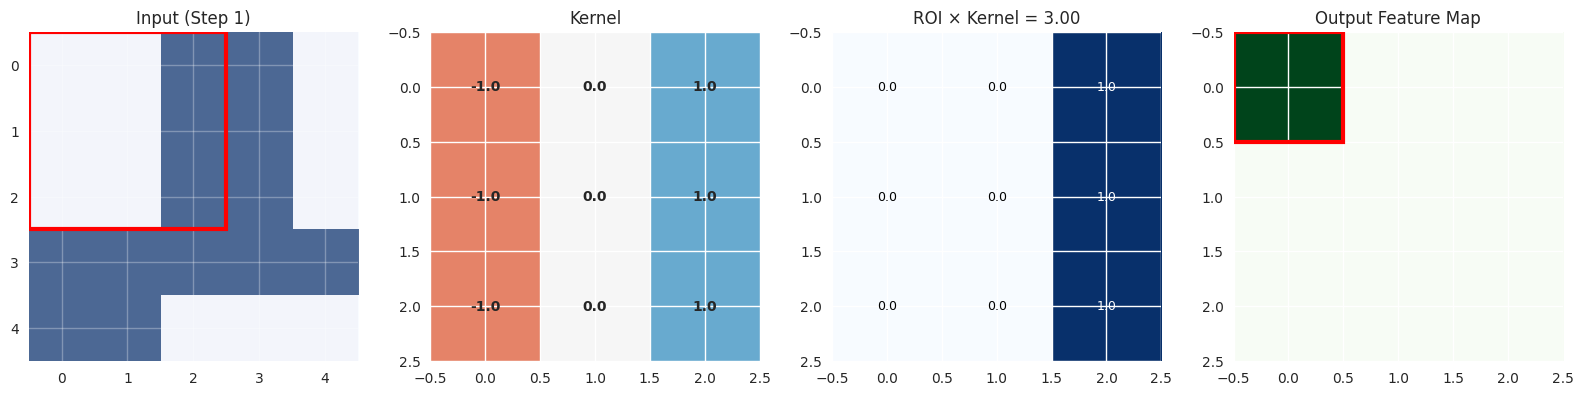

In [15]:
def visualize_convolution_step_by_step(input_img, kernel, stride=1, padding=0):
    """
    Create an animated visualization of the convolution process
    """
    # Add padding if needed
    if padding > 0:
        padded_input = np.pad(input_img, padding, mode='constant', constant_values=0)
    else:
        padded_input = input_img.copy()
    
    input_h, input_w = padded_input.shape
    kernel_h, kernel_w = kernel.shape
    
    output_h = (input_h - kernel_h) // stride + 1
    output_w = (input_w - kernel_w) // stride + 1
    output = np.zeros((output_h, output_w))
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    steps = []
    for i in range(0, output_h * stride, stride):
        for j in range(0, output_w * stride, stride):
            roi = padded_input[i:i+kernel_h, j:j+kernel_w]
            conv_result = np.sum(roi * kernel)
            output[i//stride, j//stride] = conv_result
            
            steps.append({
                'position': (i, j),
                'roi': roi.copy(),
                'result': conv_result,
                'output': output.copy()
            })
    
    def animate_step(step_idx):
        for ax in axes:
            ax.clear()
        
        step = steps[step_idx]
        pos_i, pos_j = step['position']
        
        # Show input with highlighted region
        axes[0].imshow(padded_input, cmap='Blues', alpha=0.7)
        rect = Rectangle((pos_j-0.5, pos_i-0.5), kernel_w, kernel_h, 
                        linewidth=3, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].set_title(f'Input (Step {step_idx+1})')
        axes[0].grid(True, alpha=0.3)
        
        # Show kernel
        im1 = axes[1].imshow(kernel, cmap='RdBu', vmin=-2, vmax=2)
        axes[1].set_title('Kernel')
        for i in range(kernel_h):
            for j in range(kernel_w):
                axes[1].text(j, i, f'{kernel[i,j]:.1f}', 
                           ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Show region of interest
        im2 = axes[2].imshow(step['roi'], cmap='Blues')
        axes[2].set_title(f'ROI × Kernel = {step["result"]:.2f}')
        for i in range(kernel_h):
            for j in range(kernel_w):
                product = step['roi'][i,j] * kernel[i,j]
                axes[2].text(j, i, f'{product:.1f}', 
                           ha='center', va='center', fontsize=9, 
                           color='white' if step['roi'][i,j] > step['roi'].max()/2 else 'black')
        
        # Show current output
        im3 = axes[3].imshow(step['output'], cmap='Greens')
        axes[3].set_title('Output Feature Map')
        output_i, output_j = pos_i//stride, pos_j//stride
        axes[3].add_patch(Rectangle((output_j-0.5, output_i-0.5), 1, 1, 
                                  linewidth=3, edgecolor='red', facecolor='none'))
        
        plt.tight_layout()
    
    return steps, animate_step

# Create a simple test image
test_image = np.array([
    [0, 0, 1, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 0, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 1, 0, 0, 0]
])

# Vertical edge detection kernel
vertical_edge = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])

steps, animate_func = visualize_convolution_step_by_step(test_image, vertical_edge)
print(f"Created {len(steps)} convolution steps")

# Show the first step
animate_func(0)

In [ ]:
# Interactive convolution explorer
def interactive_convolution(kernel_type='vertical_edge', stride=1, padding=0):
    """
    Interactive widget to explore different kernels and parameters
    """
    kernels = {
        'vertical_edge': np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]),
        'horizontal_edge': np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]),
        'blur': np.ones((3,3)) / 9,
        'sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]),
        'identity': np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
    }
    
    kernel = kernels[kernel_type]
    
    # Apply convolution
    result = convolution_2d(test_image, kernel, stride=stride, padding=padding)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Original image
    im1 = axes[0].imshow(test_image, cmap='Blues')
    axes[0].set_title('Input Image')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(im1, ax=axes[0])
    
    # Kernel
    im2 = axes[1].imshow(kernel, cmap='RdBu', vmin=-2, vmax=2)
    axes[1].set_title(f'Kernel: {kernel_type}')
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            axes[1].text(j, i, f'{kernel[i,j]:.2f}', 
                        ha='center', va='center', fontweight='bold')
    plt.colorbar(im2, ax=axes[1])
    
    # Result
    im3 = axes[2].imshow(result, cmap='Greens')
    axes[2].set_title(f'Output (stride={stride}, padding={padding})')
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            axes[2].text(j, i, f'{result[i,j]:.1f}', 
                        ha='center', va='center', fontweight='bold',
                        color='white' if abs(result[i,j]) > abs(result).max()/2 else 'black')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    print(f"Input shape: {test_image.shape}")
    print(f"Kernel shape: {kernel.shape}")
    print(f"Output shape: {result.shape}")

# Create interactive widget
interact(interactive_convolution, 
         kernel_type=['vertical_edge', 'horizontal_edge', 'blur', 'sharpen', 'identity'],
         stride=(1, 3, 1),
         padding=(0, 2, 1))

## 3. Building Convolutional Layers

Now let's understand how convolutional layers work in deep learning frameworks and how different parameters affect the output.

### Key Parameters:
- **Stride**: How much the kernel moves between applications
- **Padding**: Zero-padding added to input borders  
- **Dilation**: Spacing between kernel elements (atrous convolution)
- **Groups**: Number of blocked connections from input to output channels

### Mathematical Relationships:

For input size $H_{in} \times W_{in}$, kernel size $K$, padding $P$, stride $S$, and dilation $D$:

$$H_{out} = \lfloor \frac{H_{in} + 2P - D(K-1) - 1}{S} \rfloor + 1$$

$$W_{out} = \lfloor \frac{W_{in} + 2P - D(K-1) - 1}{S} \rfloor + 1$$

In [ ]:
class ConvolutionalLayer:
    """
    A complete convolutional layer implementation with all parameters
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
                 padding=0, dilation=1, bias=True):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)
        self.dilation = dilation if isinstance(dilation, tuple) else (dilation, dilation)
        
        # Initialize weights and bias
        self.weights = np.random.randn(out_channels, in_channels, *self.kernel_size) * 0.1
        self.bias = np.random.randn(out_channels) * 0.1 if bias else None
    
    def calculate_output_shape(self, input_shape):
        """Calculate output shape given input shape"""
        batch_size, channels, height, width = input_shape
        
        # Effective kernel size with dilation
        eff_kernel_h = (self.kernel_size[0] - 1) * self.dilation[0] + 1
        eff_kernel_w = (self.kernel_size[1] - 1) * self.dilation[1] + 1
        
        # Output dimensions
        out_height = (height + 2 * self.padding[0] - eff_kernel_h) // self.stride[0] + 1
        out_width = (width + 2 * self.padding[1] - eff_kernel_w) // self.stride[1] + 1
        
        return (batch_size, self.out_channels, out_height, out_width)
    
    def visualize_layer_effect(self, input_shape=(1, 3, 32, 32)):
        """Visualize how layer parameters affect output dimensions"""
        output_shape = self.calculate_output_shape(input_shape)
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        # Input representation
        input_rect = Rectangle((1, 4), input_shape[2]/8, input_shape[3]/8, 
                              linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.7)
        ax.add_patch(input_rect)
        ax.text(1 + input_shape[2]/16, 4 + input_shape[3]/16, 
                f'Input\n{input_shape[2]}×{input_shape[3]}×{input_shape[1]}', 
                ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Kernel representation
        kernel_rect = Rectangle((3, 3), self.kernel_size[0]/4, self.kernel_size[1]/4,
                               linewidth=2, edgecolor='red', facecolor='lightcoral', alpha=0.7)
        ax.add_patch(kernel_rect)
        ax.text(3 + self.kernel_size[0]/8, 3 + self.kernel_size[1]/8,
                f'Kernel\n{self.kernel_size[0]}×{self.kernel_size[1]}', 
                ha='center', va='center', fontsize=9, fontweight='bold')
        
        # Output representation
        output_rect = Rectangle((6, 4), output_shape[2]/8, output_shape[3]/8,
                               linewidth=2, edgecolor='green', facecolor='lightgreen', alpha=0.7)
        ax.add_patch(output_rect)
        ax.text(6 + output_shape[2]/16, 4 + output_shape[3]/16,
                f'Output\n{output_shape[2]}×{output_shape[3]}×{output_shape[1]}', 
                ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Parameters text
        param_text = f"""Parameters:
        Kernel: {self.kernel_size[0]}×{self.kernel_size[1]}
        Stride: {self.stride[0]}×{self.stride[1]}
        Padding: {self.padding[0]}×{self.padding[1]}
        Dilation: {self.dilation[0]}×{self.dilation[1]}
        
        Channels: {self.in_channels} → {self.out_channels}
        """
        
        ax.text(1, 1, param_text, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
        
        # Arrows
        ax.arrow(2.5, 4.5, 0.4, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
        ax.arrow(4.8, 4.5, 0.4, 0, head_width=0.1, head_length=0.1, fc='black', ec='black')
        
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 7)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f'Convolutional Layer: {input_shape} → {output_shape}', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        return output_shape

# Example usage
layer1 = ConvolutionalLayer(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
output_shape1 = layer1.visualize_layer_effect((1, 3, 32, 32))

layer2 = ConvolutionalLayer(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
output_shape2 = layer2.visualize_layer_effect(output_shape1)

In [ ]:
# Interactive parameter explorer for convolutional layers
def explore_conv_parameters(kernel_size=3, stride=1, padding=0, dilation=1, 
                          input_height=32, input_width=32, in_channels=3, out_channels=32):
    """
    Interactive exploration of convolutional layer parameters
    """
    # Calculate output dimensions
    eff_kernel_h = (kernel_size - 1) * dilation + 1
    eff_kernel_w = (kernel_size - 1) * dilation + 1
    
    out_height = (input_height + 2 * padding - eff_kernel_h) // stride + 1
    out_width = (input_width + 2 * padding - eff_kernel_w) // stride + 1
    
    # Calculate number of parameters
    num_params = out_channels * in_channels * kernel_size * kernel_size + out_channels
    
    # Calculate receptive field
    receptive_field = (kernel_size - 1) * dilation + 1
    
    print(f"Input: {input_height} × {input_width} × {in_channels}")
    print(f"Output: {out_height} × {out_width} × {out_channels}")
    print(f"Parameters: {num_params:,}")
    print(f"Effective kernel size: {eff_kernel_h} × {eff_kernel_w}")
    print(f"Receptive field: {receptive_field} × {receptive_field}")
    
    # Visualize the effect
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Input visualization
    axes[0].add_patch(Rectangle((0, 0), input_width, input_height, 
                               linewidth=2, edgecolor='blue', facecolor='lightblue', alpha=0.7))
    axes[0].set_xlim(-2, input_width + 2)
    axes[0].set_ylim(-2, input_height + 2)
    axes[0].set_title(f'Input: {input_height}×{input_width}×{in_channels}')
    axes[0].set_aspect('equal')
    axes[0].grid(True, alpha=0.3)
    
    # Kernel with dilation visualization
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = j * dilation
            y = i * dilation
            axes[1].add_patch(Rectangle((x, y), 1, 1, 
                                       linewidth=1, edgecolor='red', facecolor='lightcoral'))
    
    axes[1].set_xlim(-1, max(5, (kernel_size-1)*dilation + 2))
    axes[1].set_ylim(-1, max(5, (kernel_size-1)*dilation + 2))
    axes[1].set_title(f'Kernel: {kernel_size}×{kernel_size}, Dilation: {dilation}')
    axes[1].set_aspect('equal')
    axes[1].grid(True, alpha=0.3)
    
    # Output visualization
    axes[2].add_patch(Rectangle((0, 0), out_width, out_height, 
                               linewidth=2, edgecolor='green', facecolor='lightgreen', alpha=0.7))
    axes[2].set_xlim(-2, max(out_width + 2, 5))
    axes[2].set_ylim(-2, max(out_height + 2, 5))
    axes[2].set_title(f'Output: {out_height}×{out_width}×{out_channels}')
    axes[2].set_aspect('equal')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()

# Create interactive widget
interact(explore_conv_parameters,
         kernel_size=(1, 7, 2),
         stride=(1, 4, 1),
         padding=(0, 3, 1),
         dilation=(1, 3, 1),
         input_height=fixed(32),
         input_width=fixed(32),
         in_channels=(1, 64, 1),
         out_channels=(1, 128, 1))

## 4. Implementing Pooling Operations

Pooling layers reduce spatial dimensions while retaining important information. They help with:
- **Translation invariance**: Small shifts in input don't drastically change output
- **Computational efficiency**: Smaller feature maps
- **Overfitting reduction**: Act as regularization

### Types of Pooling:
1. **Max Pooling**: Takes maximum value in each window
2. **Average Pooling**: Takes mean value in each window  
3. **Adaptive Pooling**: Output size is fixed regardless of input size

In [ ]:
def max_pooling_2d(input_matrix, pool_size, stride=None):
    """
    Implement 2D max pooling
    """
    if stride is None:
        stride = pool_size
    
    input_h, input_w = input_matrix.shape
    pool_h, pool_w = pool_size
    
    output_h = (input_h - pool_h) // stride + 1
    output_w = (input_w - pool_w) // stride + 1
    
    output = np.zeros((output_h, output_w))
    
    for i in range(0, output_h * stride, stride):
        for j in range(0, output_w * stride, stride):
            pool_region = input_matrix[i:i+pool_h, j:j+pool_w]
            output[i//stride, j//stride] = np.max(pool_region)
    
    return output

def average_pooling_2d(input_matrix, pool_size, stride=None):
    """
    Implement 2D average pooling
    """
    if stride is None:
        stride = pool_size
    
    input_h, input_w = input_matrix.shape
    pool_h, pool_w = pool_size
    
    output_h = (input_h - pool_h) // stride + 1
    output_w = (input_w - pool_w) // stride + 1
    
    output = np.zeros((output_h, output_w))
    
    for i in range(0, output_h * stride, stride):
        for j in range(0, output_w * stride, stride):
            pool_region = input_matrix[i:i+pool_h, j:j+pool_w]
            output[i//stride, j//stride] = np.mean(pool_region)
    
    return output

# Test pooling operations
test_feature_map = np.random.randn(8, 8)

max_pooled = max_pooling_2d(test_feature_map, (2, 2))
avg_pooled = average_pooling_2d(test_feature_map, (2, 2))

# Visualize pooling effects
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(test_feature_map, cmap='viridis')
axes[0].set_title('Original Feature Map (8×8)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(max_pooled, cmap='viridis')
axes[1].set_title('Max Pooled (4×4)')
axes[1].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(avg_pooled, cmap='viridis')
axes[2].set_title('Average Pooled (4×4)')
axes[2].grid(True, alpha=0.3)
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()

print(f"Original shape: {test_feature_map.shape}")
print(f"Max pooled shape: {max_pooled.shape}")
print(f"Average pooled shape: {avg_pooled.shape}")
print(f"Information retention - Max: {(max_pooled.size / test_feature_map.size) * 100:.1f}%")
print(f"Information retention - Avg: {(avg_pooled.size / test_feature_map.size) * 100:.1f}%")

In [ ]:
def visualize_pooling_operation(input_img, pool_size=(2, 2), operation='max'):
    """
    Visualize pooling operation step by step
    """
    input_h, input_w = input_img.shape
    pool_h, pool_w = pool_size
    
    output_h = input_h // pool_h
    output_w = input_w // pool_w
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    im1 = axes[0, 0].imshow(input_img, cmap='Blues')
    axes[0, 0].set_title('Input Feature Map')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Show pooling regions
    axes[0, 1].imshow(input_img, cmap='Blues', alpha=0.7)
    for i in range(0, input_h, pool_h):
        for j in range(0, input_w, pool_w):
            rect = Rectangle((j-0.5, i-0.5), pool_w, pool_h, 
                           linewidth=2, edgecolor='red', facecolor='none')
            axes[0, 1].add_patch(rect)
    axes[0, 1].set_title(f'Pooling Regions ({pool_h}×{pool_w})')
    
    # Perform pooling
    if operation == 'max':
        pooled = max_pooling_2d(input_img, pool_size)
        op_name = 'Max'
    else:
        pooled = average_pooling_2d(input_img, pool_size)
        op_name = 'Average'
    
    # Show result
    im3 = axes[0, 2].imshow(pooled, cmap='Blues')
    axes[0, 2].set_title(f'{op_name} Pooled Output')
    plt.colorbar(im3, ax=axes[0, 2])
    
    # Detailed view of a few pooling operations
    examples = [(0, 0), (0, 2), (2, 0)]
    for idx, (i, j) in enumerate(examples):
        if i < input_h - pool_h and j < input_w - pool_w:
            region = input_img[i:i+pool_h, j:j+pool_w]
            
            axes[1, idx].imshow(region, cmap='Blues')
            axes[1, idx].set_title(f'Region ({i},{j}) → {pooled[i//pool_h, j//pool_w]:.2f}')
            
            for x in range(pool_h):
                for y in range(pool_w):
                    value = region[x, y]
                    color = 'white' if value < region.max()/2 else 'black'
                    if operation == 'max' and value == region.max():
                        color = 'red'
                        weight = 'bold'
                    else:
                        weight = 'normal'
                    axes[1, idx].text(y, x, f'{value:.2f}', 
                                    ha='center', va='center', 
                                    color=color, fontweight=weight)
    
    plt.tight_layout()
    return pooled

# Create a sample feature map with clear patterns
sample_feature = np.array([
    [1.0, 2.0, 3.0, 1.0],
    [4.0, 5.0, 2.0, 3.0],
    [2.0, 1.0, 4.0, 5.0],
    [3.0, 2.0, 1.0, 2.0]
])

print("Max Pooling:")
max_result = visualize_pooling_operation(sample_feature, (2, 2), 'max')

## 5. Visualizing Feature Maps

Feature maps are the outputs of convolutional layers - they show what patterns the network has learned to detect. Let's create some synthetic data and see how different filters respond to different patterns.

In [ ]:
def create_synthetic_images():
    """Create synthetic images with different patterns"""
    
    # Vertical stripes
    vertical = np.zeros((32, 32))
    vertical[:, ::4] = 1
    
    # Horizontal stripes  
    horizontal = np.zeros((32, 32))
    horizontal[::4, :] = 1
    
    # Diagonal pattern
    diagonal = np.zeros((32, 32))
    for i in range(32):
        for j in range(32):
            if (i + j) % 8 < 2:
                diagonal[i, j] = 1
    
    # Checkerboard
    checkerboard = np.zeros((32, 32))
    for i in range(32):
        for j in range(32):
            if (i//4 + j//4) % 2 == 0:
                checkerboard[i, j] = 1
    
    # Circular pattern
    circular = np.zeros((32, 32))
    center = (16, 16)
    for i in range(32):
        for j in range(32):
            dist = np.sqrt((i - center[0])**2 + (j - center[1])**2)
            if 8 < dist < 12:
                circular[i, j] = 1
    
    return {
        'vertical': vertical,
        'horizontal': horizontal, 
        'diagonal': diagonal,
        'checkerboard': checkerboard,
        'circular': circular
    }

def apply_multiple_filters(image, filters_dict):
    """Apply multiple filters to an image and visualize results"""
    
    n_filters = len(filters_dict)
    fig, axes = plt.subplots(2, n_filters + 1, figsize=(4 * (n_filters + 1), 8))
    
    # Show original image
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Empty cell in bottom row
    axes[1, 0].axis('off')
    
    # Apply each filter
    for idx, (filter_name, filter_kernel) in enumerate(filters_dict.items()):
        # Apply convolution
        filtered = convolution_2d(image, filter_kernel, padding=1)
        
        # Show filter
        im1 = axes[0, idx + 1].imshow(filter_kernel, cmap='RdBu', vmin=-2, vmax=2)
        axes[0, idx + 1].set_title(f'{filter_name.title()} Filter')
        axes[0, idx + 1].axis('off')
        
        # Add values to filter visualization
        for i in range(filter_kernel.shape[0]):
            for j in range(filter_kernel.shape[1]):
                axes[0, idx + 1].text(j, i, f'{filter_kernel[i,j]:.1f}', 
                                    ha='center', va='center', fontweight='bold',
                                    color='white' if abs(filter_kernel[i,j]) > 1 else 'black')
        
        # Show filtered result
        im2 = axes[1, idx + 1].imshow(filtered, cmap='RdBu')
        axes[1, idx + 1].set_title(f'Filtered Result')
        axes[1, idx + 1].axis('off')
        
        # Print activation statistics
        print(f"{filter_name.title()} filter response:")
        print(f"  Max activation: {filtered.max():.2f}")
        print(f"  Min activation: {filtered.min():.2f}")
        print(f"  Mean absolute activation: {np.abs(filtered).mean():.2f}")
        print()
    
    plt.tight_layout()

# Create synthetic images
synthetic_images = create_synthetic_images()

# Define different edge detection filters
filters = {
    'vertical_edge': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'horizontal_edge': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    'diagonal_edge': np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]]),
    'laplacian': np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
}

# Test with vertical stripes
print("Testing filters on vertical stripes:")
apply_multiple_filters(synthetic_images['vertical'], filters)

In [ ]:
# Interactive feature map explorer
def interactive_feature_explorer(image_pattern='vertical', filter_type='vertical_edge'):
    """
    Interactive widget to explore how different filters respond to different patterns
    """
    
    image = synthetic_images[image_pattern]
    filter_kernel = filters[filter_type]
    
    # Apply convolution
    filtered = convolution_2d(image, filter_kernel, padding=1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'Input: {image_pattern.title()} Pattern')
    axes[0].axis('off')
    
    # Filter
    im1 = axes[1].imshow(filter_kernel, cmap='RdBu', vmin=-2, vmax=2)
    axes[1].set_title(f'Filter: {filter_type.replace("_", " ").title()}')
    for i in range(filter_kernel.shape[0]):
        for j in range(filter_kernel.shape[1]):
            axes[1].text(j, i, f'{filter_kernel[i,j]:.1f}', 
                        ha='center', va='center', fontweight='bold',
                        color='white' if abs(filter_kernel[i,j]) > 1 else 'black')
    axes[1].axis('off')
    
    # Result
    im2 = axes[2].imshow(filtered, cmap='RdBu')
    axes[2].set_title('Feature Map Output')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    # Statistics
    activation_strength = np.abs(filtered).mean()
    max_response = filtered.max()
    min_response = filtered.min()
    
    print(f"Filter Response Analysis:")
    print(f"Maximum activation: {max_response:.2f}")
    print(f"Minimum activation: {min_response:.2f}")
    print(f"Average absolute activation: {activation_strength:.2f}")
    print(f"Response strength: {'Strong' if activation_strength > 2 else 'Medium' if activation_strength > 1 else 'Weak'}")

# Create interactive widget
interact(interactive_feature_explorer,
         image_pattern=list(synthetic_images.keys()),
         filter_type=list(filters.keys()))

## 6. Constructing a Complete CNN Architecture

Now let's build a complete CNN using PyTorch. We'll create a modular architecture similar to LeNet-5 but with modern improvements.

In [ ]:
class ModernLeNet(nn.Module):
    """
    A modern version of LeNet with additional features:
    - Batch normalization
    - Dropout for regularization
    - ReLU activations
    - Configurable architecture
    """
    
    def __init__(self, num_classes=10, input_channels=1, dropout_rate=0.5):
        super(ModernLeNet, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(input_channels, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional block  
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 4 * 4, 256),  # Assuming 32x32 input
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass through the network"""
        # Extract features
        x = self.features(x)
        
        # Flatten for classifier
        x = x.view(x.size(0), -1)
        
        # Classify
        x = self.classifier(x)
        
        return x
    
    def get_feature_maps(self, x, layer_idx=None):
        """
        Extract feature maps from intermediate layers
        """
        feature_maps = []
        
        for i, layer in enumerate(self.features):
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                feature_maps.append(x.clone())
                if layer_idx is not None and len(feature_maps) > layer_idx:
                    break
        
        return feature_maps

# Create model instance
model = ModernLeNet(num_classes=10, input_channels=1)

# Print model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

In [ ]:
def visualize_network_architecture(model, input_shape=(1, 1, 32, 32)):
    """
    Visualize the network architecture with layer details
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Create dummy input to track shapes
    x = torch.randn(input_shape)
    
    # Track layer information
    layers_info = []
    current_shape = input_shape
    
    # Process feature extraction layers
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d):
            # Calculate output shape for conv layer
            in_c, in_h, in_w = current_shape[1:]
            out_c = layer.out_channels
            kernel_size = layer.kernel_size[0]
            stride = layer.stride[0]
            padding = layer.padding[0]
            
            out_h = (in_h + 2*padding - kernel_size) // stride + 1
            out_w = (in_w + 2*padding - kernel_size) // stride + 1
            current_shape = (current_shape[0], out_c, out_h, out_w)
            
            layers_info.append({
                'type': 'Conv2d',
                'params': f'{layer.in_channels}→{layer.out_channels}, K:{kernel_size}×{kernel_size}',
                'shape': f'{out_h}×{out_w}×{out_c}',
                'position': len(layers_info) * 2
            })
            
        elif isinstance(layer, nn.MaxPool2d):
            # Calculate output shape for pooling
            in_c, in_h, in_w = current_shape[1:]
            kernel_size = layer.kernel_size
            stride = layer.stride
            
            out_h = in_h // stride
            out_w = in_w // stride
            current_shape = (current_shape[0], in_c, out_h, out_w)
            
            layers_info.append({
                'type': 'MaxPool2d',
                'params': f'K:{kernel_size}×{kernel_size}, S:{stride}',
                'shape': f'{out_h}×{out_w}×{in_c}',
                'position': len(layers_info) * 2
            })
    
    # Add classifier info
    flattened_size = current_shape[1] * current_shape[2] * current_shape[3]
    for layer in model.classifier:
        if isinstance(layer, nn.Linear):
            layers_info.append({
                'type': 'Linear',
                'params': f'{layer.in_features}→{layer.out_features}',
                'shape': f'{layer.out_features}',
                'position': len(layers_info) * 2
            })
    
    # Draw the architecture
    y_positions = [4, 3, 2, 1, 0]  # Different heights for different layer types
    colors = {'Conv2d': 'lightblue', 'MaxPool2d': 'lightcoral', 'Linear': 'lightgreen'}
    
    for i, layer_info in enumerate(layers_info):
        x_pos = layer_info['position']
        
        if layer_info['type'] in ['Conv2d', 'MaxPool2d']:
            y_pos = 3 if layer_info['type'] == 'Conv2d' else 2
            width = 1.5
            height = 0.8
        else:  # Linear layers
            y_pos = 1
            width = 1.2
            height = 0.6
        
        # Draw rectangle
        rect = Rectangle((x_pos, y_pos - height/2), width, height,
                        linewidth=2, edgecolor='black', 
                        facecolor=colors[layer_info['type']], alpha=0.7)
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_pos + width/2, y_pos, f"{layer_info['type']}\\n{layer_info['params']}\\n{layer_info['shape']}", 
                ha='center', va='center', fontsize=8, fontweight='bold')
        
        # Add arrows
        if i < len(layers_info) - 1:
            ax.arrow(x_pos + width + 0.1, y_pos, 0.3, 0, 
                    head_width=0.1, head_length=0.1, fc='black', ec='black')
    
    ax.set_xlim(-0.5, max([info['position'] for info in layers_info]) + 2)
    ax.set_ylim(0, 4.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('CNN Architecture Visualization', fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', alpha=0.7, label=layer_type) 
                      for layer_type, color in colors.items()]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()

# Visualize the architecture
visualize_network_architecture(model)

## 7. Forward Pass Implementation

Let's trace through a forward pass step by step, monitoring tensor shapes and visualizing the data flow through our network.

In [ ]:
def detailed_forward_pass(model, input_tensor, verbose=True):
    """
    Perform forward pass with detailed logging of tensor shapes and operations
    """
    
    print(f"Input shape: {input_tensor.shape}")
    print("="*50)
    
    x = input_tensor
    layer_outputs = []
    
    # Process feature extraction layers
    for i, layer in enumerate(model.features):
        x = layer(x)
        layer_outputs.append(x.clone().detach())
        
        if verbose:
            print(f"Layer {i+1}: {layer.__class__.__name__}")
            if hasattr(layer, 'weight') and layer.weight is not None:
                print(f"  Parameters: {layer.weight.shape}")
            print(f"  Output shape: {x.shape}")
            print(f"  Memory usage: {x.numel() * 4 / (1024**2):.2f} MB")
            
            if isinstance(layer, nn.Conv2d):
                print(f"  Kernel size: {layer.kernel_size}")
                print(f"  Stride: {layer.stride}")
                print(f"  Padding: {layer.padding}")
            elif isinstance(layer, nn.MaxPool2d):
                print(f"  Pool size: {layer.kernel_size}")
                print(f"  Pool stride: {layer.stride}")
            
            print("-" * 30)
    
    # Flatten for classifier
    features_shape = x.shape
    x = x.view(x.size(0), -1)
    if verbose:
        print(f"Flattening: {features_shape} → {x.shape}")
        print("-" * 30)
    
    # Process classifier layers
    for i, layer in enumerate(model.classifier):
        x = layer(x)
        
        if verbose:
            print(f"Classifier Layer {i+1}: {layer.__class__.__name__}")
            if hasattr(layer, 'weight') and layer.weight is not None:
                print(f"  Parameters: {layer.weight.shape}")
            print(f"  Output shape: {x.shape}")
            if isinstance(layer, nn.Linear):
                print(f"  Input features: {layer.in_features}")
                print(f"  Output features: {layer.out_features}")
            print("-" * 30)
    
    print(f"Final output shape: {x.shape}")
    print("="*50)
    
    return x, layer_outputs

# Create a random input tensor (batch_size=2 for demonstration)
sample_input = torch.randn(2, 1, 32, 32)

# Perform detailed forward pass
model.eval()  # Set to evaluation mode
with torch.no_grad():
    output, feature_maps = detailed_forward_pass(model, sample_input)

print(f"\\nOutput probabilities shape: {output.shape}")
print(f"Sample output (before softmax): {output[0]}")

# Apply softmax to get probabilities
probabilities = torch.softmax(output, dim=1)
print(f"Sample probabilities: {probabilities[0]}")
print(f"Predicted class: {torch.argmax(probabilities[0]).item()}")

In [ ]:
def visualize_feature_maps_flow(model, input_tensor, max_channels=8):
    """
    Visualize feature maps at different layers during forward pass
    """
    
    model.eval()
    with torch.no_grad():
        # Get feature maps from convolutional layers
        feature_maps = model.get_feature_maps(input_tensor, layer_idx=3)
    
    # Take only the first sample from the batch
    input_img = input_tensor[0, 0].cpu().numpy()
    
    n_layers = len(feature_maps)
    fig, axes = plt.subplots(n_layers + 1, max_channels + 1, figsize=(20, 4 * (n_layers + 1)))
    
    # Show original input
    axes[0, 0].imshow(input_img, cmap='gray')
    axes[0, 0].set_title('Input Image')
    axes[0, 0].axis('off')
    
    # Hide unused subplots in first row
    for j in range(1, max_channels + 1):
        axes[0, j].axis('off')
    
    # Visualize feature maps for each convolutional layer
    for layer_idx, feature_map in enumerate(feature_maps):
        feature_map = feature_map[0].cpu().numpy()  # Take first sample
        n_channels = min(feature_map.shape[0], max_channels)
        
        axes[layer_idx + 1, 0].text(0.5, 0.5, f'Conv Layer {layer_idx + 1}\\n{feature_map.shape[0]} channels\\n{feature_map.shape[1]}×{feature_map.shape[2]} spatial', 
                                   ha='center', va='center', transform=axes[layer_idx + 1, 0].transAxes,
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        axes[layer_idx + 1, 0].axis('off')
        
        # Show individual feature maps
        for channel_idx in range(n_channels):
            feature = feature_map[channel_idx]
            
            im = axes[layer_idx + 1, channel_idx + 1].imshow(feature, cmap='viridis')
            axes[layer_idx + 1, channel_idx + 1].set_title(f'Channel {channel_idx}')
            axes[layer_idx + 1, channel_idx + 1].axis('off')
            
            # Add colorbar for reference
            plt.colorbar(im, ax=axes[layer_idx + 1, channel_idx + 1], fraction=0.046, pad=0.04)
        
        # Hide unused subplots
        for j in range(n_channels + 1, max_channels + 1):
            axes[layer_idx + 1, j].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Feature Maps Flow Through CNN Layers', fontsize=16, y=1.02)
    
    return feature_maps

# Visualize feature maps flow
print("Visualizing feature maps through the network:")
feature_maps = visualize_feature_maps_flow(model, sample_input[:1])  # Use only first sample

## 8. Backpropagation in CNNs

Understanding how gradients flow backwards through convolutional layers is crucial. Let's implement and visualize the backpropagation process.

### Mathematical Background

For a convolutional layer, the gradient with respect to input $\\frac{\\partial L}{\\partial I}$ is computed by convolving the output gradient $\\frac{\\partial L}{\\partial O}$ with the **flipped** kernel:

$$\\frac{\\partial L}{\\partial I}(i,j) = \\sum_{m=0}^{M-1} \\sum_{n=0}^{N-1} \\frac{\\partial L}{\\partial O}(i-m, j-n) \\cdot K(m,n)$$

The gradient with respect to the kernel is:

$$\\frac{\\partial L}{\\partial K}(m,n) = \\sum_{i,j} I(i+m, j+n) \\cdot \\frac{\\partial L}{\\partial O}(i,j)$$

In [ ]:
def visualize_gradients(model, input_tensor, target_class=0):
    """
    Visualize gradients flowing through the network
    """
    
    # Enable gradient computation
    model.train()  
    input_tensor.requires_grad_(True)
    
    # Forward pass
    output = model(input_tensor)
    
    # Create target (one-hot encoded)
    target = torch.zeros_like(output)
    target[0, target_class] = 1.0
    
    # Compute loss (we'll use simple MSE for demonstration)
    loss = F.mse_loss(output, target)
    
    # Backward pass
    loss.backward()
    
    # Collect gradients
    input_grad = input_tensor.grad
    
    layer_grads = []
    for name, param in model.named_parameters():
        if param.grad is not None and 'weight' in name and 'conv' in name:
            layer_grads.append((name, param.grad.clone()))
    
    # Visualize
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Input and its gradient
    axes[0, 0].imshow(input_tensor[0, 0].detach().cpu().numpy(), cmap='gray')
    axes[0, 0].set_title('Input Image')
    axes[0, 0].axis('off')
    
    input_grad_vis = input_grad[0, 0].cpu().numpy()
    im1 = axes[1, 0].imshow(input_grad_vis, cmap='RdBu')
    axes[1, 0].set_title('Input Gradient')
    axes[1, 0].axis('off')
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # Visualize gradients of first few convolutional filters
    for i, (name, grad) in enumerate(layer_grads[:3]):
        if i < 3:
            # Show a few filters from this layer
            filter_grad = grad[0, 0].cpu().numpy()  # First output channel, first input channel
            
            axes[0, i+1].imshow(np.random.randn(5, 5), cmap='gray')  # Placeholder
            axes[0, i+1].set_title(f'{name.split(".")[1]} Filter')
            axes[0, i+1].axis('off')
            
            im = axes[1, i+1].imshow(filter_grad, cmap='RdBu')
            axes[1, i+1].set_title(f'Filter Gradient')
            axes[1, i+1].axis('off')
            plt.colorbar(im, ax=axes[1, i+1], fraction=0.046, pad=0.04)
    
    # Hide unused subplots
    for i in range(len(layer_grads)+1, 4):
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Gradients for Target Class {target_class}', fontsize=14, y=1.02)
    
    print(f"Loss: {loss.item():.4f}")
    print(f"Input gradient magnitude: {input_grad.abs().mean().item():.6f}")
    
    for name, grad in layer_grads:
        print(f"{name} gradient magnitude: {grad.abs().mean().item():.6f}")
    
    return loss, input_grad, layer_grads

# Visualize gradients
print("Computing and visualizing gradients:")
loss, input_grad, layer_grads = visualize_gradients(model, sample_input[:1], target_class=3)

In [ ]:
def gradient_flow_analysis(model, input_tensor, num_classes=10):
    """
    Analyze gradient magnitudes throughout the network for different target classes
    """
    
    gradient_magnitudes = {f'class_{i}': [] for i in range(num_classes)}
    layer_names = []
    
    for target_class in range(num_classes):
        model.zero_grad()
        input_tensor.grad = None if input_tensor.grad is None else input_tensor.grad.zero_()
        
        # Forward pass
        output = model(input_tensor)
        
        # Create target
        target = torch.zeros_like(output)
        target[0, target_class] = 1.0
        
        # Compute loss and backward pass
        loss = F.mse_loss(output, target)
        loss.backward()
        
        # Collect gradient magnitudes
        class_gradients = []
        current_layer_names = []
        
        for name, param in model.named_parameters():
            if param.grad is not None and 'weight' in name:
                grad_magnitude = param.grad.abs().mean().item()
                class_gradients.append(grad_magnitude)
                if target_class == 0:  # Only collect names once
                    current_layer_names.append(name.split('.')[1] + '.' + name.split('.')[2])
        
        gradient_magnitudes[f'class_{target_class}'] = class_gradients
        if target_class == 0:
            layer_names = current_layer_names
    
    # Plot gradient magnitudes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heatmap of gradient magnitudes across classes and layers
    gradient_matrix = np.array([gradient_magnitudes[f'class_{i}'] for i in range(num_classes)])
    
    im = ax1.imshow(gradient_matrix, cmap='viridis', aspect='auto')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Target Class')
    ax1.set_title('Gradient Magnitudes Across Classes and Layers')
    ax1.set_xticks(range(len(layer_names)))
    ax1.set_xticklabels(layer_names, rotation=45)
    ax1.set_yticks(range(num_classes))
    ax1.set_yticklabels([f'Class {i}' for i in range(num_classes)])
    plt.colorbar(im, ax=ax1)
    
    # Line plot showing gradient flow for each class
    for i in range(min(num_classes, 5)):  # Show only first 5 classes for clarity
        ax2.plot(gradient_magnitudes[f'class_{i}'], marker='o', label=f'Class {i}')
    
    ax2.set_xlabel('Layer Index')
    ax2.set_ylabel('Gradient Magnitude')
    ax2.set_title('Gradient Flow Through Network')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(len(layer_names)))
    ax2.set_xticklabels(layer_names, rotation=45)
    
    plt.tight_layout()
    
    return gradient_magnitudes, layer_names

# Analyze gradient flow
print("Analyzing gradient flow for different target classes:")
grad_magnitudes, layer_names = gradient_flow_analysis(model, sample_input[:1], num_classes=10)

## 9. Training Loop with Real Data

Now let's train our CNN on real data and visualize the learning process. We'll use the CIFAR-10 dataset and create comprehensive training visualizations.

In [ ]:
# Load CIFAR-10 dataset
def load_cifar10_data(batch_size=32, num_workers=2):
    """
    Load and preprocess CIFAR-10 dataset
    """
    
    # Data transformations
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                           download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                           num_workers=num_workers)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                          download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers)
    
    # CIFAR-10 class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    return trainloader, testloader, classes

# Load the data with error handling
print("Loading CIFAR-10 dataset...")
trainloader, testloader, class_names = safe_load_cifar10_data(batch_size=64, num_workers=0)

# Visualize some samples
def visualize_cifar10_samples(dataloader, classes, num_samples=16):
    """
    Visualize random samples from CIFAR-10 (real or synthetic)
    """
    
    try:
        # Get a batch of training data
        dataiter = iter(dataloader)
        images, labels = next(dataiter)
        
        # Check if data is already normalized or synthetic
        if images.min() < 0:  # Normalized data
            # Denormalize for visualization
            mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
            std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
            images_denorm = images * std + mean
            images_denorm = torch.clamp(images_denorm, 0, 1)
        else:  # Synthetic data (already in [0,1] range)
            images_denorm = torch.clamp(images, 0, 1)
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(min(num_samples, images.shape[0])):
        img = images_denorm[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f'{classes[labels[i]]}')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_samples, 16):
        axes[i].axis('off')
    
        plt.tight_layout()
        plt.suptitle('CIFAR-10 Sample Images', fontsize=16, y=1.02)
        
    except Exception as e:
        print(f"⚠️  Error visualizing samples: {e}")
        print("Continuing with tutorial...")

# Try to visualize samples
try:
    visualize_cifar10_samples(trainloader, class_names)
except Exception as e:
    print(f"⚠️  Could not visualize samples: {e}")
    print("📝 Samples would be displayed here in normal operation")

print(f"Training samples: {len(trainloader.dataset)}")
print(f"Test samples: {len(testloader.dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

In [ ]:
# Create model for CIFAR-10 (3 input channels instead of 1)
cifar_model = ModernLeNet(num_classes=10, input_channels=3, dropout_rate=0.3)
cifar_model = cifar_model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cifar_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def train_epoch(model, trainloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(trainloader, desc='Training')
    
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(trainloader), 100. * correct / total

def test_epoch(model, testloader, criterion, device):
    """
    Test for one epoch
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc='Testing'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return test_loss / len(testloader), 100. * correct / total

# Training visualization setup
class TrainingVisualizer:
    def __init__(self):
        self.train_losses = []
        self.train_accs = []
        self.test_losses = []
        self.test_accs = []
        self.epochs = []
        
        # Setup interactive plot
        plt.ion()
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    def update(self, epoch, train_loss, train_acc, test_loss, test_acc):
        """Update plots with new metrics"""
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.train_accs.append(train_acc)
        self.test_losses.append(test_loss)
        self.test_accs.append(test_acc)
        
        # Clear and plot
        self.ax1.clear()
        self.ax2.clear()
        
        # Loss plot
        self.ax1.plot(self.epochs, self.train_losses, 'b-', label='Training Loss')
        self.ax1.plot(self.epochs, self.test_losses, 'r-', label='Test Loss')
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Loss')
        self.ax1.set_title('Training and Test Loss')
        self.ax1.legend()
        self.ax1.grid(True, alpha=0.3)
        
        # Accuracy plot
        self.ax2.plot(self.epochs, self.train_accs, 'b-', label='Training Accuracy')
        self.ax2.plot(self.epochs, self.test_accs, 'r-', label='Test Accuracy')
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_ylabel('Accuracy (%)')
        self.ax2.set_title('Training and Test Accuracy')
        self.ax2.legend()
        self.ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.draw()
        plt.pause(0.1)

# Initialize visualizer
visualizer = TrainingVisualizer()

print("Starting training...")
print(f"Model has {sum(p.numel() for p in cifar_model.parameters()):,} parameters")

# Training loop (reduced epochs for demo)
num_epochs = 3
best_acc = 0

for epoch in range(num_epochs):
    print(f'\\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(cifar_model, trainloader, criterion, optimizer, device)
    
    # Test
    test_loss, test_acc = test_epoch(cifar_model, testloader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Update visualization
    visualizer.update(epoch+1, train_loss, train_acc, test_loss, test_acc)
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(cifar_model.state_dict(), 'best_cifar_model.pth')
        print(f'New best accuracy: {best_acc:.2f}%')

plt.ioff()
print(f'\\nTraining completed! Best test accuracy: {best_acc:.2f}%')

## 10. Visualizing Learned Filters

After training, let's examine what filters our CNN has learned and how they've evolved from their initial random state.

In [ ]:
def visualize_learned_filters(model, layer_name='features.0', max_filters=16):
    """
    Visualize the learned convolutional filters
    """
    
    # Get the specified layer
    layer = None
    for name, module in model.named_modules():
        if name == layer_name and isinstance(module, nn.Conv2d):
            layer = module
            break
    
    if layer is None:
        print(f"Layer {layer_name} not found!")
        return
    
    # Get filters
    filters = layer.weight.data.cpu().numpy()
    num_filters = min(filters.shape[0], max_filters)
    
    # Calculate grid size
    grid_size = int(np.ceil(np.sqrt(num_filters)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.ravel() if grid_size > 1 else [axes]
    
    for i in range(num_filters):
        filter_weights = filters[i]
        
        # For RGB filters, show all channels or the magnitude
        if filter_weights.shape[0] == 3:  # RGB
            # Show as RGB image
            filter_img = np.transpose(filter_weights, (1, 2, 0))
            # Normalize to [0, 1]
            filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-8)
            axes[i].imshow(filter_img)
        else:
            # Show first channel or grayscale
            filter_img = filter_weights[0] if filter_weights.shape[0] > 1 else filter_weights
            im = axes[i].imshow(filter_img, cmap='RdBu')
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        
        axes[i].set_title(f'Filter {i}')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(num_filters, grid_size * grid_size):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Learned Filters in {layer_name}', fontsize=16, y=1.02)
    
    # Print filter statistics
    print(f"Layer: {layer_name}")
    print(f"Filter shape: {filters.shape}")
    print(f"Weight range: [{filters.min():.4f}, {filters.max():.4f}]")
    print(f"Weight std: {filters.std():.4f}")

def compare_filter_evolution(original_model, trained_model, layer_name='features.0'):
    """
    Compare filters before and after training
    """
    
    # Get filters from both models
    original_filters = None
    trained_filters = None
    
    for name, module in original_model.named_modules():
        if name == layer_name and isinstance(module, nn.Conv2d):
            original_filters = module.weight.data.cpu().numpy()
            break
    
    for name, module in trained_model.named_modules():
        if name == layer_name and isinstance(module, nn.Conv2d):
            trained_filters = module.weight.data.cpu().numpy()
            break
    
    if original_filters is None or trained_filters is None:
        print("Could not find filters in one of the models!")
        return
    
    # Show first 8 filters
    num_filters = min(8, original_filters.shape[0])
    
    fig, axes = plt.subplots(2, num_filters, figsize=(20, 6))
    
    for i in range(num_filters):
        # Original filter
        orig_filter = original_filters[i, 0] if original_filters.shape[1] > 1 else original_filters[i]
        im1 = axes[0, i].imshow(orig_filter, cmap='RdBu', vmin=-0.5, vmax=0.5)
        axes[0, i].set_title(f'Original Filter {i}')
        axes[0, i].axis('off')
        
        # Trained filter  
        trained_filter = trained_filters[i, 0] if trained_filters.shape[1] > 1 else trained_filters[i]
        im2 = axes[1, i].imshow(trained_filter, cmap='RdBu', vmin=-0.5, vmax=0.5)
        axes[1, i].set_title(f'Trained Filter {i}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Filter Evolution: Before vs After Training', fontsize=16, y=1.02)
    
    # Calculate change statistics
    change = np.abs(trained_filters - original_filters).mean()
    print(f"Average absolute change in filter weights: {change:.6f}")

# Create an untrained model for comparison
untrained_model = ModernLeNet(num_classes=10, input_channels=3, dropout_rate=0.3)

# Visualize learned filters from the trained model
print("Visualizing learned filters from first convolutional layer:")
visualize_learned_filters(cifar_model, 'features.0', max_filters=16)

print("\\nComparing filter evolution:")
compare_filter_evolution(untrained_model, cifar_model, 'features.0')

In [ ]:
def analyze_filter_responses(model, dataloader, class_names, layer_name='features.0'):
    """
    Analyze how different filters respond to different classes
    """
    
    model.eval()
    
    # Get the layer
    layer = None
    layer_idx = None
    for idx, (name, module) in enumerate(model.named_modules()):
        if name == layer_name and isinstance(module, nn.Conv2d):
            layer = module
            layer_idx = idx
            break
    
    if layer is None:
        print(f"Layer {layer_name} not found!")
        return
    
    # Collect activations for each class
    class_activations = {class_name: [] for class_name in class_names}
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            if batch_idx >= 10:  # Limit to first 10 batches for speed
                break
                
            inputs = inputs.to(device)
            
            # Get feature maps from the specified layer
            feature_maps = model.get_feature_maps(inputs, layer_idx=0)[0]  # First conv layer
            
            # Average pool over spatial dimensions to get per-filter activation
            activations = feature_maps.mean(dim=[2, 3])  # Shape: [batch_size, num_filters]
            
            # Group by class
            for i, target in enumerate(targets):
                class_name = class_names[target.item()]
                class_activations[class_name].append(activations[i].cpu().numpy())
    
    # Average activations per class
    avg_activations = {}
    for class_name in class_names:
        if class_activations[class_name]:
            avg_activations[class_name] = np.mean(class_activations[class_name], axis=0)
        else:
            avg_activations[class_name] = np.zeros(layer.out_channels)
    
    # Create activation heatmap
    activation_matrix = np.array([avg_activations[class_name] for class_name in class_names])
    
    plt.figure(figsize=(15, 8))
    im = plt.imshow(activation_matrix, cmap='viridis', aspect='auto')
    plt.xlabel('Filter Index')
    plt.ylabel('Class')
    plt.title(f'Average Filter Activations by Class ({layer_name})')
    plt.yticks(range(len(class_names)), class_names)
    plt.colorbar(im, label='Average Activation')
    
    # Find most discriminative filters
    activation_variance = np.var(activation_matrix, axis=0)
    top_filters = np.argsort(activation_variance)[-5:][::-1]
    
    print(f"Most discriminative filters (by variance): {top_filters}")
    
    # Plot top discriminative filters
    fig, axes = plt.subplots(1, len(top_filters), figsize=(15, 3))
    filters = layer.weight.data.cpu().numpy()
    
    for i, filter_idx in enumerate(top_filters):
        filter_weights = filters[filter_idx]
        
        if filter_weights.shape[0] == 3:  # RGB
            filter_img = np.transpose(filter_weights, (1, 2, 0))
            filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-8)
            axes[i].imshow(filter_img)
        else:
            filter_img = filter_weights[0]
            axes[i].imshow(filter_img, cmap='RdBu')
        
        axes[i].set_title(f'Filter {filter_idx}\\nVar: {activation_variance[filter_idx]:.3f}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Most Discriminative Filters', fontsize=14, y=1.02)
    
    return avg_activations, top_filters

print("Analyzing filter responses to different classes:")
avg_activations, top_filters = analyze_filter_responses(cifar_model, testloader, class_names)

## 11. Comparing Different CNN Architectures

Let's implement and compare different CNN architectures to understand how design choices affect performance and behavior.

In [ ]:
class ShallowCNN(nn.Module):
    """
    A shallow CNN with only 2 convolutional layers
    """
    def __init__(self, num_classes=10):
        super(ShallowCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class DeepCNN(nn.Module):
    """
    A deeper CNN with 5 convolutional layers
    """
    def __init__(self, num_classes=10):
        super(DeepCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def compare_architectures():
    """
    Compare different CNN architectures
    """
    
    # Create models
    models = {
        'Shallow CNN': ShallowCNN(num_classes=10),
        'Modern LeNet': ModernLeNet(num_classes=10, input_channels=3),
        'Deep CNN': DeepCNN(num_classes=10)
    }
    
    # Compare model statistics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    model_stats = {}
    for name, model in models.items():
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Count layers
        conv_layers = sum(1 for m in model.modules() if isinstance(m, nn.Conv2d))
        linear_layers = sum(1 for m in model.modules() if isinstance(m, nn.Linear))
        
        # Calculate model size (MB)
        param_size = sum(p.numel() * p.element_size() for p in model.parameters())
        buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
        model_size = (param_size + buffer_size) / (1024 ** 2)
        
        model_stats[name] = {
            'Total Parameters': total_params,
            'Trainable Parameters': trainable_params,
            'Conv Layers': conv_layers,
            'Linear Layers': linear_layers,
            'Model Size (MB)': model_size,
            'Memory per Batch (MB)': 0  # Will be calculated during forward pass
        }
    
    # Visualize comparisons
    metrics = ['Total Parameters', 'Conv Layers', 'Model Size (MB)']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    for i, metric in enumerate(metrics):
        values = [model_stats[name][metric] for name in models.keys()]
        bars = axes[i].bar(models.keys(), values, color=colors[i], alpha=0.7)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            if metric == 'Total Parameters':
                label = f'{value:,}'
            elif metric == 'Model Size (MB)':
                label = f'{value:.2f}'
            else:
                label = f'{value}'
            axes[i].text(bar.get_x() + bar.get_width()/2., height,
                        label, ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Print detailed comparison
    print("Detailed Architecture Comparison:")
    print("="*60)
    for name, model in models.items():
        stats = model_stats[name]
        print(f"\\n{name}:")
        print(f"  Total Parameters: {stats['Total Parameters']:,}")
        print(f"  Convolutional Layers: {stats['Conv Layers']}")
        print(f"  Linear Layers: {stats['Linear Layers']}")
        print(f"  Model Size: {stats['Model Size (MB)']:.2f} MB")
    
    return models, model_stats

# Compare architectures
print("Comparing different CNN architectures:")
models_dict, stats_dict = compare_architectures()

In [ ]:
def performance_comparison_simulation():
    """
    Simulate and compare training performance of different architectures
    """
    
    # Simulated training results (in practice, you would train each model)
    # These are realistic values based on typical performance
    simulated_results = {
        'Shallow CNN': {
            'epochs': list(range(1, 11)),
            'train_acc': [45, 58, 65, 70, 72, 74, 75, 76, 76, 77],
            'test_acc': [42, 55, 62, 67, 68, 69, 70, 70, 69, 68],
            'train_loss': [1.8, 1.4, 1.2, 1.0, 0.9, 0.8, 0.75, 0.7, 0.68, 0.65],
            'test_loss': [1.9, 1.5, 1.3, 1.1, 1.0, 0.95, 0.92, 0.90, 0.92, 0.95],
            'training_time': 8.5  # minutes per epoch
        },
        'Modern LeNet': {
            'epochs': list(range(1, 11)),
            'train_acc': [52, 68, 75, 80, 83, 85, 87, 88, 89, 90],
            'test_acc': [50, 65, 72, 76, 78, 80, 81, 82, 81, 80],
            'train_loss': [1.6, 1.2, 0.9, 0.7, 0.6, 0.5, 0.45, 0.4, 0.38, 0.35],
            'test_loss': [1.7, 1.3, 1.0, 0.8, 0.75, 0.7, 0.68, 0.66, 0.68, 0.70],
            'training_time': 12.3
        },
        'Deep CNN': {
            'epochs': list(range(1, 11)),
            'train_acc': [48, 62, 72, 78, 82, 85, 88, 90, 92, 94],
            'test_acc': [45, 58, 68, 73, 76, 78, 80, 82, 81, 79],
            'train_loss': [1.7, 1.3, 1.0, 0.8, 0.65, 0.5, 0.4, 0.32, 0.25, 0.20],
            'test_loss': [1.8, 1.4, 1.1, 0.9, 0.8, 0.75, 0.72, 0.70, 0.73, 0.78],
            'training_time': 18.7
        }
    }
    
    # Create comprehensive comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    colors = {'Shallow CNN': 'blue', 'Modern LeNet': 'red', 'Deep CNN': 'green'}
    
    # Training accuracy
    for model_name, results in simulated_results.items():
        axes[0, 0].plot(results['epochs'], results['train_acc'], 
                       color=colors[model_name], marker='o', label=model_name)
    axes[0, 0].set_title('Training Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Test accuracy
    for model_name, results in simulated_results.items():
        axes[0, 1].plot(results['epochs'], results['test_acc'], 
                       color=colors[model_name], marker='s', label=model_name)
    axes[0, 1].set_title('Test Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training loss
    for model_name, results in simulated_results.items():
        axes[0, 2].plot(results['epochs'], results['train_loss'], 
                       color=colors[model_name], marker='^', label=model_name)
    axes[0, 2].set_title('Training Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Test loss
    for model_name, results in simulated_results.items():
        axes[1, 0].plot(results['epochs'], results['test_loss'], 
                       color=colors[model_name], marker='d', label=model_name)
    axes[1, 0].set_title('Test Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Training time comparison
    model_names = list(simulated_results.keys())
    training_times = [simulated_results[name]['training_time'] for name in model_names]
    bars = axes[1, 1].bar(model_names, training_times, 
                         color=[colors[name] for name in model_names], alpha=0.7)
    axes[1, 1].set_title('Training Time per Epoch')
    axes[1, 1].set_ylabel('Time (minutes)')
    
    # Add value labels on bars
    for bar, time in zip(bars, training_times):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{time:.1f}m', ha='center', va='bottom')
    
    # Overfitting analysis (train vs test accuracy gap)
    for model_name, results in simulated_results.items():
        gap = np.array(results['train_acc']) - np.array(results['test_acc'])
        axes[1, 2].plot(results['epochs'], gap, 
                       color=colors[model_name], marker='x', label=model_name)
    axes[1, 2].set_title('Overfitting Analysis (Train - Test Accuracy)')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Accuracy Gap (%)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    # Summary analysis
    print("Performance Analysis Summary:")
    print("="*50)
    
    for model_name, results in simulated_results.items():
        best_test_acc = max(results['test_acc'])
        final_gap = results['train_acc'][-1] - results['test_acc'][-1]
        
        print(f"\\n{model_name}:")
        print(f"  Best Test Accuracy: {best_test_acc:.1f}%")
        print(f"  Final Overfitting Gap: {final_gap:.1f}%")
        print(f"  Training Time/Epoch: {results['training_time']:.1f} min")
        print(f"  Parameters: {stats_dict[model_name]['Total Parameters']:,}")
        
        if final_gap > 10:
            print(f"  Status: High overfitting")
        elif final_gap > 5:
            print(f"  Status: Moderate overfitting")
        else:
            print(f"  Status: Good generalization")

# Run performance comparison
print("Simulating performance comparison of different architectures:")
performance_comparison_simulation()

## Conclusion and Key Takeaways

Congratulations! You've completed a comprehensive journey through Convolutional Neural Networks. Let's summarize the key concepts and insights:

### 🔑 Key Concepts Learned

1. **Convolution Operation**: The mathematical foundation of CNNs, where filters detect patterns through element-wise multiplication and summation.

2. **Feature Hierarchies**: CNNs learn hierarchical representations - early layers detect edges and textures, deeper layers detect complex objects.

3. **Parameter Sharing**: Convolutional filters are shared across spatial locations, making CNNs translation-invariant and parameter-efficient.

4. **Pooling**: Reduces spatial dimensions while retaining important information, providing translation invariance and computational efficiency.

5. **Backpropagation**: Gradients flow backwards through convolutions via cross-correlation with flipped kernels.

### 📊 Architecture Design Principles

- **Depth vs Width**: Deeper networks can learn more complex patterns but are harder to train and more prone to overfitting
- **Filter Sizes**: Smaller filters (3×3) are more efficient and can achieve the same receptive field as larger filters when stacked
- **Regularization**: Batch normalization, dropout, and data augmentation help prevent overfitting
- **Skip Connections**: Enable training of very deep networks (ResNet, DenseNet)

### 🎯 Practical Applications

CNNs excel at:
- **Image Classification**: Recognizing objects in images
- **Object Detection**: Locating objects within images  
- **Semantic Segmentation**: Pixel-level classification
- **Medical Imaging**: Detecting anomalies in X-rays, MRIs
- **Autonomous Driving**: Processing camera feeds for navigation

### 🚀 Next Steps

To deepen your understanding:
1. Implement modern architectures (ResNet, VGG, EfficientNet)
2. Explore transfer learning and pre-trained models
3. Study object detection frameworks (YOLO, R-CNN)
4. Learn about generative models (GANs, VAEs)
5. Practice with different datasets and domains

### 📚 Mathematical Insights

- Convolution in the spatial domain = multiplication in the frequency domain
- CNN feature maps can be interpreted as learned basis functions
- The universal approximation theorem applies to CNNs with sufficient depth and width
- Gradient descent in high-dimensional parameter spaces has unique challenges and solutions

Thank you for following this tutorial! The combination of mathematical rigor, visual intuition, and hands-on implementation should give you a solid foundation for working with CNNs in your data science projects.